<a href="https://colab.research.google.com/github/Hernan-G-94/Laboratorio_analisis_de_datos/blob/main/Trabajo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ETL**

# **Laboratorio de Análisis de Datos**
**Objetivo:** aplicar un proceso ETL completo, realizar EDA con pandas y responder 3 preguntas de negocio.
**Entorno:** Google Colab — Python, pandas, SQLAlchemy.

## Extracción

In [27]:
# Instalamos las dependencias en caso de ser necesario.
!pip install sqlalchemy pymysql pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.0 MB/s eta 0:00:00


In [29]:
# Imports y configuración inicial
from google.colab import drive
import chardet
import pandas as pd
import numpy as np
from sqlalchemy import create_engine


# Montamos Google Drive para acceder al archivo
drive.mount('/content/drive', force_remount=True)

files_archivo = '/content/drive/MyDrive/Análisis_de_datos/w_mean_priv.csv'
with open(files_archivo, 'rb') as f:
    result = chardet.detect(f.read())

try:
  df = pd.read_csv(files_archivo, encoding=result['encoding'], sep=',', decimal=',')
  print('Extracción de datos exitosa')
except FileNotFoundError:
  print(f'No se encontró el archivo: {files_archivo}')

# opciones de pandas para mejor visualización
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 200)

Mounted at /content/drive
Extracción de datos exitosa


In [30]:
# Primeras inspecciones
print(df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all'))

(387234, 4)


,fecha,zona_prov,clae2,w_mean
0,2007-01-01,BUENOS AIRES,1,1199
1,2007-01-01,BUENOS AIRES,2,1036
2,2007-01-01,BUENOS AIRES,3,2955
3,2007-01-01,BUENOS AIRES,5,1154
4,2007-01-01,BUENOS AIRES,6,9615


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387234 entries, 0 to 387233
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   fecha      387234 non-null  object
 1   zona_prov  387234 non-null  object
 2   clae2      387234 non-null  int64 
 3   w_mean     387234 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 11.8+ MB


None

,fecha,zona_prov,clae2,w_mean
count,387234,387234,387234.000000,3.872340e+05
unique,203,24,NaN,NaN
top,2012-03-01,BUENOS AIRES,NaN,NaN
freq,1928,17156,NaN,NaN
mean,NaN,NaN,60.690288,4.944868e+04
std,NaN,NaN,109.446584,1.191521e+05
min,NaN,NaN,1.000000,-9.900000e+01
25%,NaN,NaN,24.000000,3.813000e+03
50%,NaN,NaN,50.000000,1.204500e+04
75%,NaN,NaN,73.000000,4.195600e+04


## Transformación: (Limpieza, tipos y variables derivadas)

In [31]:
# Convertir fecha a tipo datetime
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Revisar valores únicos y duplicados
print("Duplicados:", df.duplicated().sum())
print("Zonas únicas:", df['zona_prov'].nunique())

# Ver algunas zonas para ver si hay inconsistencias de formato
print(df['zona_prov'].unique()[:10])
df['año'] = df['fecha'].dt.year.astype('Int64')   # conserva NaT como <NA>
df['mes'] = df['fecha'].dt.month.astype('Int64')
df['año_mes'] = df['fecha'].dt.to_period('M')

Duplicados: 0
Zonas únicas: 24
['BUENOS AIRES' 'CAPITAL FEDERAL' 'CATAMARCA' 'CHACO' 'CHUBUT' 'CORDOBA'
 'CORRIENTES' 'ENTRE RIOS' 'FORMOSA' 'JUJUY']


In [32]:
# Normalizar nombres de provincia
df['zona_prov'] = df['zona_prov'].str.strip().str.upper().str.normalize('NFKD')

In [33]:
# Renombrar columnas a algo más cómodo
df = df.rename(columns={
    'zona_prov': 'provincia',
    'clae2': 'actividad_codigo',
    'w_mean': 'promedio_ponderado'
    })

In [34]:
# Tipos: convertir promedio a float
df['promedio_ponderado'] = pd.to_numeric(df['promedio_ponderado'], errors='coerce').astype('float64')

In [35]:
# Revisar valores faltantes
print("Nulos por columna:\n", df.isna().sum())

Nulos por columna:
 fecha                 0
provincia             0
actividad_codigo      0
promedio_ponderado    0
año                   0
mes                   0
año_mes               0
dtype: int64


In [36]:
# Investigar valores negativos / sentinels
print("Resumen w_mean (antes de limpiar):")
display(df['promedio_ponderado'].describe())
print("Valores mínimos frecuencias:")
display(df.loc[df['promedio_ponderado'] <= 0, 'promedio_ponderado'].value_counts().head(20))

Resumen w_mean (antes de limpiar):


,promedio_ponderado
count,3.872340e+05
mean,4.944868e+04
std,1.191521e+05
min,-9.900000e+01
25%,3.813000e+03
50%,1.204500e+04
75%,4.195600e+04
max,7.876528e+06


Valores mínimos frecuencias:


,count
promedio_ponderado,
-99.0,9164
0.0,43


In [37]:
# Limpiamos promerio_ponderado
df.loc[df['promedio_ponderado'] == -99, 'promedio_ponderado'] = np.nan

In [38]:
# Duplicados en combinación clave
clave = ['fecha', 'provincia', 'actividad_codigo']
dups = df.duplicated(subset=clave).sum()
print("Duplicados según clave (fecha,provincia,actividad):", dups)
if dups > 0:
    display(df[df.duplicated(subset=clave, keep=False)].sort_values(clave).head(30))

Duplicados según clave (fecha,provincia,actividad): 0


In [41]:
# Convertimos para hacer la carga a SQLite sin errores
df['año_mes'] = df['año_mes'].astype(str)

## Carga

In [42]:
# Definir la ruta de salida para guardar el nuevo CSV
ruta_salida = '/content/drive/MyDrive/Análisis_de_datos/w_mean_priv_1.csv'

# Guardar el DataFrame en un nuevo archivo CSV
df.to_csv(ruta_salida, index=False, sep=',')

print(f'Archivo CSV guardado en: {ruta_salida}')

Archivo CSV guardado en: /content/drive/MyDrive/Análisis_de_datos/w_mean_priv_1.csv


In [43]:
# CARGA a SQLite con SQLAlchemy
sqlite_path = '/content/drive/MyDrive/Análisis_de_datos/w_mean_priv_clean.sqlite'
engine = create_engine(f"sqlite:///{sqlite_path}")
df.to_sql('w_mean_priv', con=engine, if_exists='replace', index=False)
print('Guardado en SQLite:', sqlite_path)

Guardado en SQLite: /content/drive/MyDrive/Análisis_de_datos/w_mean_priv_clean.sqlite


# EDA: Análisis Exploratorio de Datos

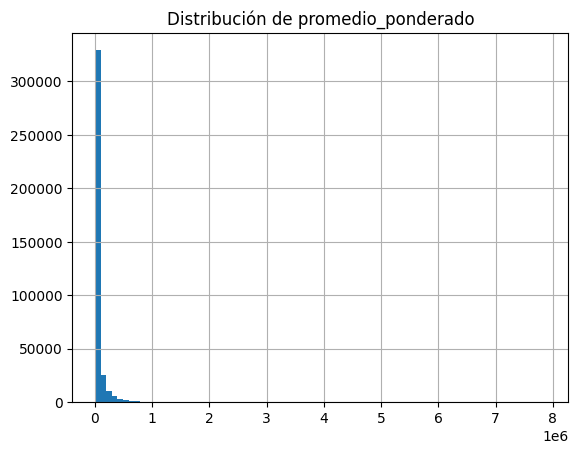

In [45]:
import matplotlib.pyplot as plt

plt.figure()
df['promedio_ponderado'].dropna().hist(bins=80)
plt.title('Distribución de promedio_ponderado')
plt.show()

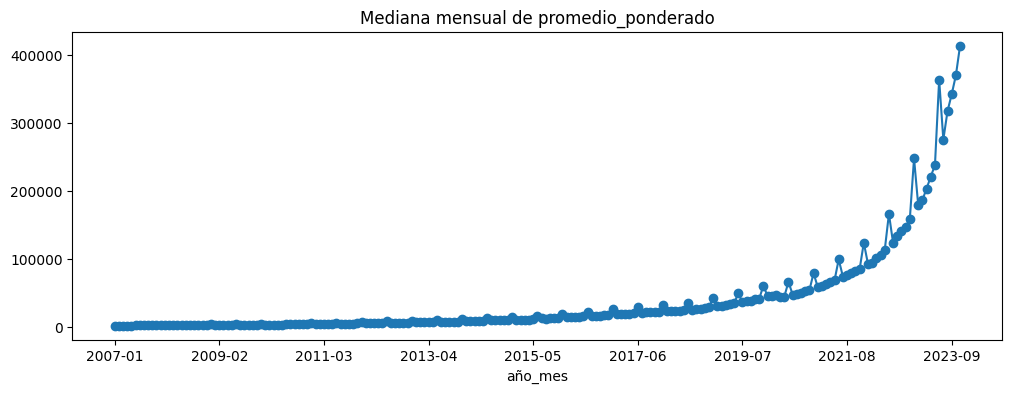

In [46]:
# Series de tiempo: promedio por mes

serie = df.groupby('año_mes')['promedio_ponderado'].median()
serie.plot(figsize=(12,4), marker='o', legend=False)
plt.title('Mediana mensual de promedio_ponderado')
plt.show()

<Axes: xlabel='actividad_codigo'>

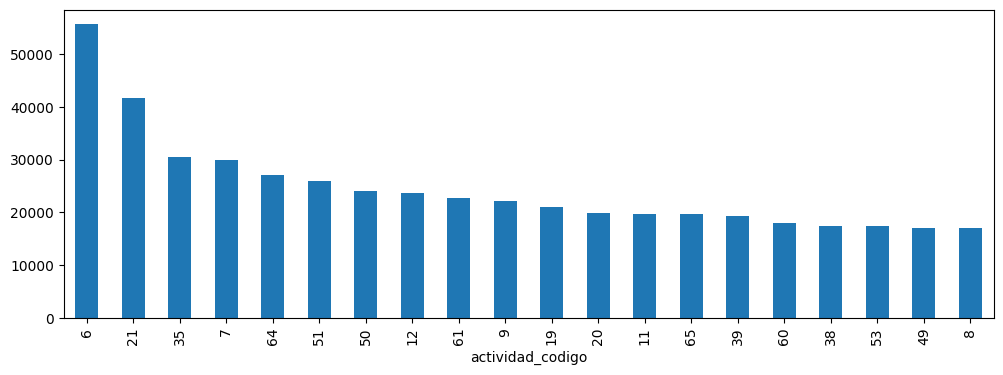

In [47]:
# Top actividades por promedio (global y por provincia)

top_act = df.groupby('actividad_codigo')['promedio_ponderado'].median().sort_values(ascending=False).head(20)
top_act.plot(kind='bar', figsize=(12,4))

## Preguntas de negocio — Análisis, evidencia y conclusión
Cada pregunta incluye la tabla con la evidencia, gráfico (cuando aplica) y una interpretación.

,promedio_ponderado
provincia,
TIERRA DEL FUEGO,19187.5
CAPITAL FEDERAL,18416.0
SANTA CRUZ,17550.0
NEUQUEN,17355.5
CHUBUT,16557.0
BUENOS AIRES,14970.0
RIO NEGRO,14125.0
SANTA FE,13848.5
CORDOBA,13075.0


<Axes: xlabel='año_mes'>

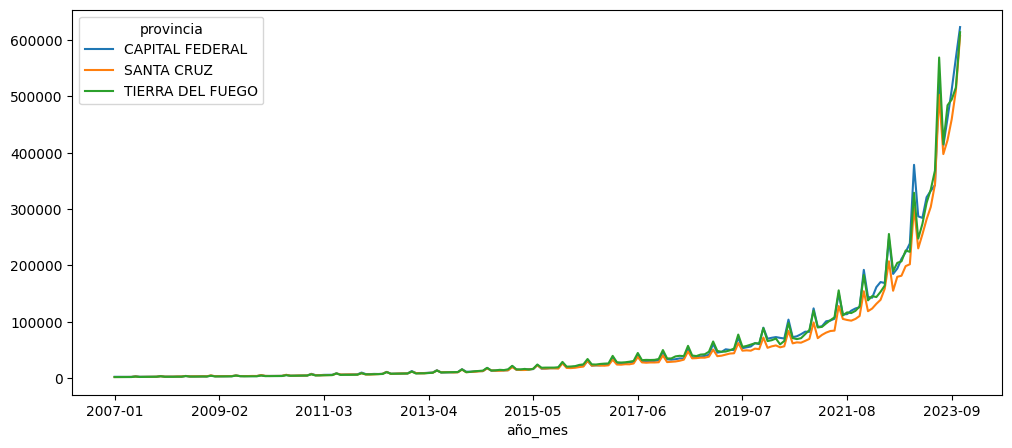

In [48]:
# Pregunta 1 — ¿Qué provincias presentan las mayores medianas de promedio_ponderado y cómo cambió eso en el tiempo?

med_prov = df.groupby('provincia')['promedio_ponderado'].median().sort_values(ascending=False)
display(med_prov.head(10))

# Evolución temporal de top 3 provincias
top3 = med_prov.head(3).index
df[df['provincia'].isin(top3)].groupby(['año_mes','provincia'])['promedio_ponderado'].median().unstack().plot(figsize=(12,5))

In [49]:
# Pregunta 2 — ¿Qué actividades económicas concentran los promedios más altos y en qué provincias?

top_act = df.groupby('actividad_codigo')['promedio_ponderado'].median().sort_values(ascending=False).head(10)
display(top_act)

# Por provincia para una actividad top
actividad_ej = top_act.index[0]
df[df['actividad_codigo']==actividad_ej].groupby('provincia')['promedio_ponderado'].median().sort_values(ascending=False).head(10)

,promedio_ponderado
actividad_codigo,
6,55645.0
21,41721.0
35,30582.0
7,29945.0
64,27013.0
51,25929.0
50,24150.0
12,23603.0
61,22824.5


,promedio_ponderado
provincia,
SANTIAGO DEL ESTERO,405374.0
MISIONES,362451.0
ENTRE RIOS,218271.0
TIERRA DEL FUEGO,86420.0
CAPITAL FEDERAL,81828.0
NEUQUEN,77615.0
SANTA CRUZ,75656.0
CHUBUT,70054.0
RIO NEGRO,70020.0


<Axes: xlabel='mes'>

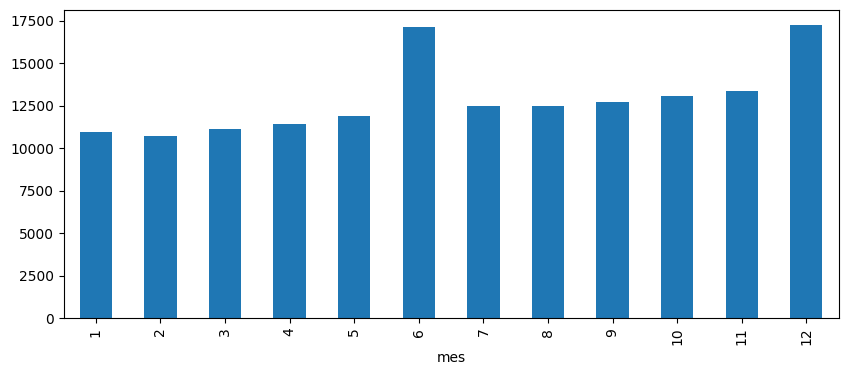

In [50]:
# Pregunta 3 — ¿Hay estacionalidad mensual en los promedios?

monthly = df.groupby('mes')['promedio_ponderado'].median()
monthly.plot(kind='bar', figsize=(10,4))